In [71]:
# initialization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader
import re
from sklearn.preprocessing import StandardScaler

import nltk
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import time

nltk.download('punkt')
nltk.download('stopwords')

np.random.seed(42)

[nltk_data] Downloading package punkt to /Users/fionchai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fionchai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import data

In [72]:
%%script false --no-raise-error # comment this if you dont have the dev_set

# import dataset
train_set = pd.read_csv('train.csv')

test_set = pd.read_csv('test.csv')

# from train_set sample development set
dev_set = train_set.sample(n=500, replace=False)

# remove dev set from train set
train_set = train_set.drop(dev_set.index)

# check
print(train_set.shape, dev_set.shape, test_set.shape)

# save to dataframe
dev_set.to_csv("dev_set.csv", index=False)
train_set.to_csv("train_set_modified.csv", index=False)

In [73]:
train_set = pd.read_csv('train_set_modified.csv')
dev_set = pd.read_csv('dev_set.csv')
test_set = pd.read_csv('test.csv')

## Preprocess data


In [74]:
# word2vec

# download the word2vec-google-news-300
w2v = gensim.downloader.load('word2vec-google-news-300')

In [75]:
# select four classes: 0, 1, 2, 3
# 4 and 5 will be OTHERS (4)

# for train_set
train_set.loc[train_set['label-coarse'] > 4, 'label-coarse'] = 4

# for dev_set
dev_set.loc[dev_set['label-coarse'] > 4, 'label-coarse'] = 4

# for test_set
test_set.loc[test_set['label-coarse'] > 4, 'label-coarse'] = 4


In [76]:
# neural network transforming the input for each word to its final vector representation
def token(sentence):

    # keep only english words
    sentence = re.sub("[^a-zA-Z]"," ",sentence)

    # converting to lower case and splitting

    # stop word removal
    words = sentence.split()
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words]
    filtered_sentence = ' '.join(filtered_words)

    # handle empty string after removing stop words
    if not len(filtered_sentence):
        filtered_sentence = sentence

    token = word_tokenize(filtered_sentence)
    return token

In [77]:
train_set['cleaned_text'] = train_set['text'].apply(token)

train_set.head()

,label-coarse,label-fine,text,cleaned_text
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]"
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]"
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]"
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]"
4,2,3,What is the full form of .com ?,"[full, form, com]"


In [78]:
max_length = train_set['cleaned_text'].str.len().max()

# get the embedding shape of the model
embed_shape = len(w2v['test'])
padded_sentences = []

for index, row in train_set.iterrows():

    sentence = row['cleaned_text']

    # get word embedding of each word
    word_embeddings = []

    for word in sentence:
        # check if the word is present in the model
        if word in w2v.key_to_index:
            word_embeddings.append(w2v[word])
        else:
             word_embeddings.append(np.zeros(shape=(embed_shape)))

    # pad sentences to max_length
    pad_width = max_length - len(sentence)

    padded_sentence = np.pad(np.array(word_embeddings), ((pad_width, 0), (0, 0)), mode= "constant", constant_values= [0])
    padded_sentences.append(padded_sentence)
    # print(padded_sentence.shape) # max_length x 300

train_set['vector'] = padded_sentences

train_set.head()


,label-coarse,label-fine,text,cleaned_text,vector
0,0,0,How did serfdom develop in and then leave Russ...,"[serfdom, develop, leave, russia]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,1,What films featured the character Popeye Doyle ?,"[films, featured, character, popeye, doyle]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0,0,How can I find a list of celebrities ' real na...,"[find, list, celebrities, real, names]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,2,What fowl grabs the spotlight after the Chines...,"[fowl, grabs, spotlight, chinese, year, monkey]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,2,3,What is the full form of .com ?,"[full, form, com]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [79]:
def preprocess_x(dataset):
  dataset['cleaned_text'] = dataset['text'].apply(token)
  max_length = dataset['cleaned_text'].str.len().max()

  # get the embedding shape of the model
  embed_shape = len(w2v['test'])
  padded_sentences = []

  for index, row in dataset.iterrows():

      sentence = row['cleaned_text']

      # get word embedding of each word
      word_embeddings = []

      for word in sentence:
          # check if the word is present in the model
          if word in w2v.key_to_index:
              word_embeddings.append(w2v[word])
          else:
              word_embeddings.append(np.zeros(shape=(embed_shape)))

      # pad sentences to max_length
      pad_width = max_length - len(sentence)

      padded_sentence = np.pad(np.array(word_embeddings), ((pad_width, 0), (0, 0)), mode= "constant", constant_values= [0])
      padded_sentences.append(padded_sentence)

  x = torch.tensor(np.array(padded_sentences))

  return x

X_dev = preprocess_x(dev_set)
X_train = preprocess_x(train_set)
print(X_train.shape)
# print(torch.isnan(x_dev).any().item())


torch.Size([4952, 18, 300])


### Prepare data for training

In [80]:
def encode_y_label(df, num_classes): # one hot encoding
  encoded_labels = df['label-coarse'].apply(lambda label: list(np.eye(num_classes)[label]))
  df['encoded-coarse-label'] = encoded_labels
  return df

train_set = encode_y_label(train_set, 5)
dev_set = encode_y_label(dev_set, 5)

In [81]:
# split into X and y
X_train = preprocess_x(train_set)
y_train = train_set['encoded-coarse-label']

X_dev = preprocess_x(dev_set)
y_dev = dev_set['encoded-coarse-label']

# mini-batch strategy
batch_size = 32

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X =torch.tensor(X, dtype=torch.float64)
        self.y =torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

train_data = CustomDataset(X_train, y_train)
dev_data = CustomDataset(X_dev, y_dev)



/var/folders/s6/9xhy3ssd0snfcfh5ys7848y40000gn/T/ipykernel_36633/1526020532.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X =torch.tensor(X, dtype=torch.float64)


##  LSTM model

In [82]:
HIDDEN_SIZE = 128
OUTPUT_SIZE = 5
NUM_LAYERS = 1


class simple_lstm(nn.Module):
    def __init__(
                    self,
                    input_size = 300,
                    hidden_size= HIDDEN_SIZE,
                    output_size= OUTPUT_SIZE,
                    num_layers= NUM_LAYERS,
                   # dropout_rate= 0.2,
                    bidirectional= True,
                ):

        super().__init__()
        # Model body
        self.lstm = nn.LSTM(input_size= input_size, hidden_size= hidden_size, bidirectional= bidirectional, num_layers= num_layers, batch_first= True)

        # Model head
        self.head = nn.Sequential(
            nn.Linear((2 if bidirectional else 1) * hidden_size, output_size),
           # nn.Dropout(dropout_rate),
            nn.Softmax(dim= 2)
        )

    def __call__(self, input):
        out, _ = self.lstm(input) # out dim = 32 x max_length x 256

        #  apply max pooling along the sequence dimension
        pooled_output = F.max_pool2d(out, kernel_size=(out.size(1), 1), stride=(out.size(1), 1)) # pooled output dim = 32 x 1 x 256, out.size(1) to match max_length of dataset

        return self.head(pooled_output) # expected dim = 32 x 1 x 5

## Find optimal batch size

In [83]:
input_dim = embed_shape
hidden_dim = 128
output_dim = 5
layer_dim = 300
batch_sizes = [2, 4, 8, 16, 24, 32, 64, 128, 256, 512]
model = simple_lstm(input_dim, 128, 5, 1)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [84]:
def calculate_accuracy(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    return accuracy_score(y_true, y_pred)

In [85]:
num_epochs = 20
best_accuracy = 0.0
max_patience = 5
current_patience = 0
accuracy_list_batch_size = {}
time_taken_batch_size = {}
loss_batch_size = {}

for batch_size in batch_sizes:
  model = simple_lstm(input_dim, 128, 5, 1)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

  for epoch in range(num_epochs):
    model.train()
    total_training_loss = 0.0
    total_dev_loss = 0.0

    for x_batch, y_batch in train_loader:
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)
    print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs

        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)
      print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))



    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break
      
  end_time = time.time()
  time_taken_batch_size[batch_size] =  end_time - start_time 
  accuracy_list_batch_size[batch_size] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_batch_size[batch_size] = sum(dev_loss_list)/len(dev_loss_list)


Epoch: 0, training set loss: 1.38783
Epoch: 0, dev set loss: 1.42000
Accuracy: 48.20%
Epoch: 1, training set loss: 1.25319
Epoch: 1, dev set loss: 1.16071
Accuracy: 74.60%
Epoch: 2, training set loss: 1.13731
Epoch: 2, dev set loss: 1.15143
Accuracy: 74.40%
Epoch: 3, training set loss: 1.09324
Epoch: 3, dev set loss: 1.13168
Accuracy: 76.00%
Epoch: 4, training set loss: 1.05885
Epoch: 4, dev set loss: 1.12627
Accuracy: 77.60%
Epoch: 5, training set loss: 1.03022
Epoch: 5, dev set loss: 1.11848
Accuracy: 77.80%
Epoch: 6, training set loss: 1.01257
Epoch: 6, dev set loss: 1.12421
Accuracy: 78.40%
Epoch: 7, training set loss: 0.99916
Epoch: 7, dev set loss: 1.09871
Accuracy: 80.00%
Epoch: 8, training set loss: 0.98729
Epoch: 8, dev set loss: 1.11443
Accuracy: 78.40%
Epoch: 9, training set loss: 0.97990
Epoch: 9, dev set loss: 1.11462
Accuracy: 78.40%
Epoch: 10, training set loss: 0.97097
Epoch: 10, dev set loss: 1.10531
Accuracy: 79.80%
Epoch: 11, training set loss: 0.96460
Epoch: 11, dev

In [86]:
accuracy_list_batch_size

{2: 0.7697999999999999,
 4: 0.7763,
 8: 0.7752,
 16: 0.7686000000000001,
 24: 0.7616999999999999,
 32: 0.7478000000000001,
 64: 0.7508,
 128: 0.7108,
 256: 0.7022,
 512: 0.6173}

Text(0.5, 1.0, 'Accuracy against Batch size')

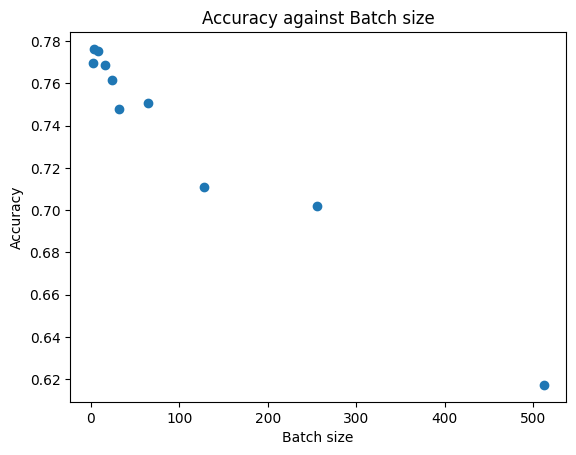

In [87]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_batch_size.keys(), accuracy_list_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Accuracy")
plt.title("Accuracy against Batch size")

Text(0.5, 1.0, 'Time taken against Batch size')

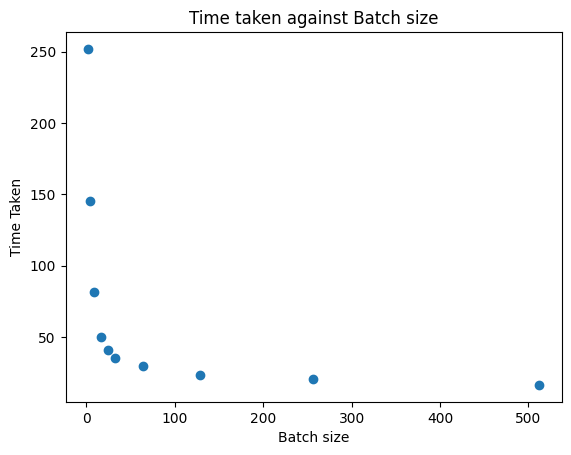

In [88]:
# Plot dev time against batch size
plt.scatter(time_taken_batch_size.keys(), time_taken_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Time Taken")
plt.title("Time taken against Batch size")

Text(0.5, 1.0, 'Loss against Batch size')

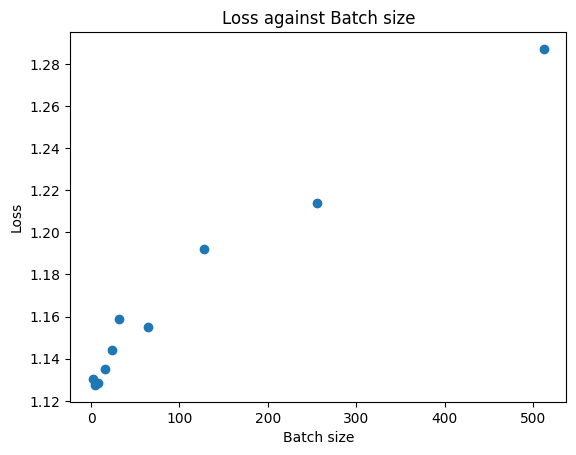

In [89]:
# Plot dev loss against batch size
plt.scatter(loss_batch_size.keys(), loss_batch_size.values())
plt.xlabel("Batch size")
plt.ylabel("Loss")
plt.title("Loss against Batch size")

Based on the result shown above, batch size of 24 is chosen for it's accuracy and time taken.

## Find optimal number of hidden layers

In [90]:
input_dim = embed_shape
hidden_dim = 128
output_dim = 5
layer_dim = 300
batch_size = 24
num_layers = [1, 2, 3, 4, 5, 6]
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [91]:
def calculate_accuracy(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    return accuracy_score(y_true, y_pred)

In [92]:
num_epochs = 20
best_accuracy = 0.0
max_patience = 5
current_patience = 0
accuracy_list_num_layers = {}
time_taken_num_layers = {}
loss_num_layers = {}

for layer in num_layers:
  model = simple_lstm(input_dim, 128, 5, layer)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

  for epoch in range(num_epochs):
    model.train()
    total_training_loss = 0.0
    total_dev_loss = 0.0

    for x_batch, y_batch in train_loader:
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)
    print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs

        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)
      print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))



    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break
    
  end_time = time.time()
  time_taken_num_layers[layer] =  end_time - start_time 
  accuracy_list_num_layers[layer] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_num_layers[layer] = sum(dev_loss_list)/len(dev_loss_list)


Epoch: 0, training set loss: 1.43058
Epoch: 0, dev set loss: 1.27443
Accuracy: 65.60%
Epoch: 1, training set loss: 1.23423
Epoch: 1, dev set loss: 1.20023
Accuracy: 70.20%
Epoch: 2, training set loss: 1.17604
Epoch: 2, dev set loss: 1.15942
Accuracy: 74.60%
Epoch: 3, training set loss: 1.14129
Epoch: 3, dev set loss: 1.15511
Accuracy: 75.40%
Epoch: 4, training set loss: 1.12644
Epoch: 4, dev set loss: 1.16976
Accuracy: 74.00%
Epoch: 5, training set loss: 1.10869
Epoch: 5, dev set loss: 1.14249
Accuracy: 75.60%
Epoch: 6, training set loss: 1.09202
Epoch: 6, dev set loss: 1.13509
Accuracy: 77.20%
Epoch: 7, training set loss: 1.06694
Epoch: 7, dev set loss: 1.13987
Accuracy: 75.40%
Epoch: 8, training set loss: 1.06123
Epoch: 8, dev set loss: 1.13490
Accuracy: 76.40%
Epoch: 9, training set loss: 1.05191
Epoch: 9, dev set loss: 1.12539
Accuracy: 77.80%
Epoch: 10, training set loss: 1.04166
Epoch: 10, dev set loss: 1.11883
Accuracy: 78.40%
Epoch: 11, training set loss: 1.03395
Epoch: 11, dev

In [93]:
accuracy_list_num_layers

{1: 0.7635000000000002,
 2: 0.7499,
 3: 0.6607999999999999,
 4: 0.4737,
 5: 0.6051999999999998,
 6: 0.3302000000000001}

Text(0.5, 1.0, 'Accuracy against Number of Layers')

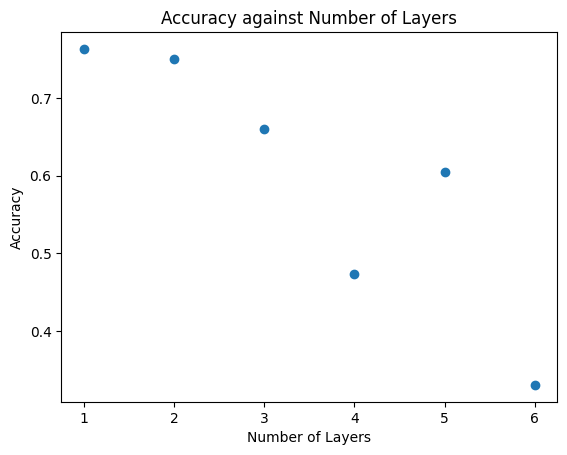

In [94]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_num_layers.keys(), accuracy_list_num_layers.values())
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.title("Accuracy against Number of Layers")

Text(0.5, 1.0, 'Time taken against Number of Layers')

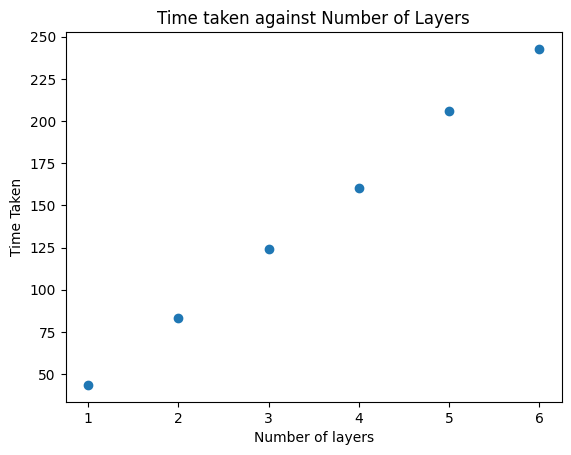

In [95]:
# Plot dev time against batch size
plt.scatter(time_taken_num_layers.keys(), time_taken_num_layers.values())
plt.xlabel("Number of layers")
plt.ylabel("Time Taken")
plt.title("Time taken against Number of Layers")

Text(0.5, 1.0, 'Loss against Number of Layers')

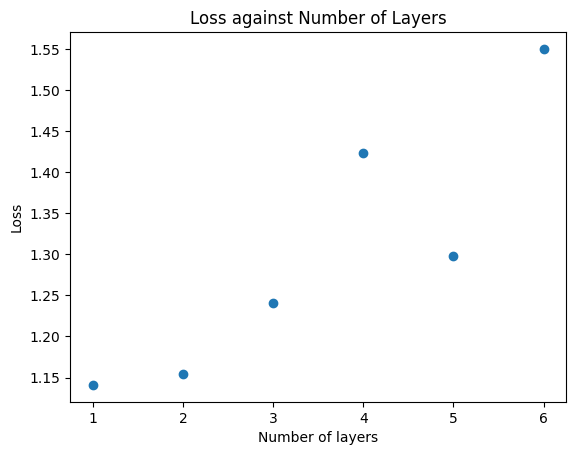

In [96]:
# Plot dev loss against batch size
plt.scatter(loss_num_layers.keys(), loss_num_layers.values())
plt.xlabel("Number of layers")
plt.ylabel("Loss")
plt.title("Loss against Number of Layers")

As seen in the result, having 1 hidden layer results in the highest accuracy and shortest time taken. Hence, 1 hidden layer is used.

## Find optimal number of hidden neurons

In [97]:
input_dim = embed_shape
hidden_dims = [64, 138, 256, 512]
output_dim = 5
layer_dim = 300
batch_size = 24
criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [98]:
def calculate_accuracy(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    return accuracy_score(y_true, y_pred)

In [99]:
num_epochs = 20
best_accuracy = 0.0
max_patience = 5
current_patience = 0
accuracy_list_hidden_dims = {}
time_taken_hidden_dims = {}
loss_hidden_dims = {}

for hidden_dim in hidden_dims:
  model = simple_lstm(input_dim, hidden_dim, 5, 1)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  dev_accuracy_list = []
  dev_loss_list = []
  start_time = time.time()
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  dev_loader = DataLoader(dev_data, batch_size=batch_size, shuffle=True)

  for epoch in range(num_epochs):
    model.train()
    total_training_loss = 0.0
    total_dev_loss = 0.0

    for x_batch, y_batch in train_loader:
      outputs = model(x_batch.float()) # forward pass
      optimizer.zero_grad() # calculate the gradient, manually setting to 0

      # obtain the loss function
      loss = criterion(outputs.squeeze(1), y_batch)

      loss.backward() #calculates the loss of the loss function

      optimizer.step() #improve from loss, i.e backprop

      total_training_loss += loss.item()

    average_loss = total_training_loss / len(train_loader)
    print("Epoch: %d, training set loss: %1.5f" % (epoch, average_loss))

    # evaluate on dev set
    model.eval()
    with torch.no_grad():
      all_true_labels = []
      all_predicted_labels = []
      for inputs in dev_loader:
        x_batch, y_batch = inputs

        # forward pass
        y_pred = model(x_batch.float())
        loss = criterion(y_pred.squeeze(1), y_batch)

        total_dev_loss += loss.item()

        predicted_labels = torch.argmax(y_pred.squeeze(1), dim=1)

        y_batch = torch.argmax(y_batch, dim=1)

        all_true_labels.extend(y_batch.tolist())
        all_predicted_labels.extend(predicted_labels.tolist())

      average_dev_loss = total_dev_loss / len(dev_loader)
      dev_loss_list.append(average_dev_loss)
      print("Epoch: %d, dev set loss: %1.5f" % (epoch, average_dev_loss))



    accuracy = calculate_accuracy(torch.tensor(all_true_labels), torch.tensor(all_predicted_labels))
    dev_accuracy_list.append(accuracy)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model.state_dict()
    # else:
    #   current_patience += 1
    #   if current_patience >= max_patience:
    #       print(f"Early stopping after {epoch} epochs.")
    #       break
    
  end_time = time.time()
  time_taken_hidden_dims[hidden_dim] =  end_time - start_time 
  accuracy_list_hidden_dims[hidden_dim] = sum(dev_accuracy_list)/len(dev_accuracy_list)
  loss_hidden_dims[hidden_dim] = sum(dev_loss_list)/len(dev_loss_list)


Epoch: 0, training set loss: 1.46538
Epoch: 0, dev set loss: 1.33145
Accuracy: 59.20%
Epoch: 1, training set loss: 1.27184
Epoch: 1, dev set loss: 1.22234
Accuracy: 69.20%
Epoch: 2, training set loss: 1.19432
Epoch: 2, dev set loss: 1.16290
Accuracy: 74.60%
Epoch: 3, training set loss: 1.15839
Epoch: 3, dev set loss: 1.16135
Accuracy: 74.20%
Epoch: 4, training set loss: 1.13357
Epoch: 4, dev set loss: 1.13926
Accuracy: 77.00%
Epoch: 5, training set loss: 1.11488
Epoch: 5, dev set loss: 1.14294
Accuracy: 76.40%
Epoch: 6, training set loss: 1.09505
Epoch: 6, dev set loss: 1.12739
Accuracy: 78.00%
Epoch: 7, training set loss: 1.08208
Epoch: 7, dev set loss: 1.14195
Accuracy: 75.60%
Epoch: 8, training set loss: 1.07201
Epoch: 8, dev set loss: 1.12263
Accuracy: 78.00%
Epoch: 9, training set loss: 1.06100
Epoch: 9, dev set loss: 1.12517
Accuracy: 78.40%
Epoch: 10, training set loss: 1.05217
Epoch: 10, dev set loss: 1.11712
Accuracy: 77.60%
Epoch: 11, training set loss: 1.04393
Epoch: 11, dev

In [100]:
accuracy_list_hidden_dims

{64: 0.7593999999999999,
 138: 0.7525000000000002,
 256: 0.784,
 512: 0.7655000000000001}

Text(0.5, 1.0, 'Accuracy against Number of Hidden Neurons')

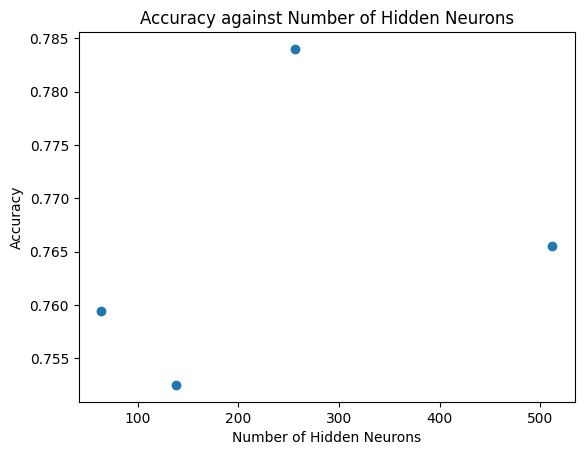

In [101]:
# Plot dev accuracies against batch size
plt.scatter(accuracy_list_hidden_dims.keys(), accuracy_list_hidden_dims.values())
plt.xlabel("Number of Hidden Neurons")
plt.ylabel("Accuracy")
plt.title("Accuracy against Number of Hidden Neurons")

Text(0.5, 1.0, 'Time taken against Number of Hidden Neurons')

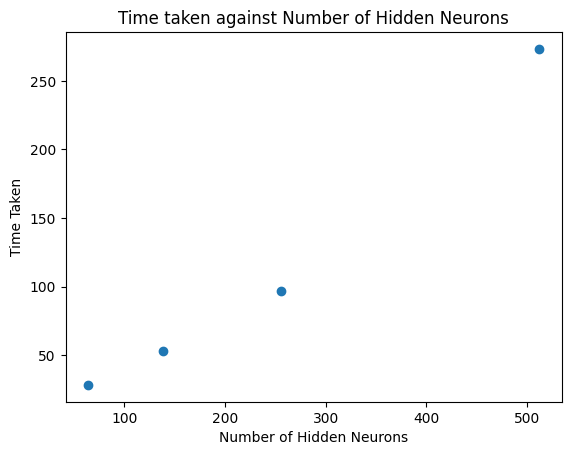

In [102]:
# Plot dev time against batch size
plt.scatter(time_taken_hidden_dims.keys(), time_taken_hidden_dims.values())
plt.xlabel("Number of Hidden Neurons")
plt.ylabel("Time Taken")
plt.title("Time taken against Number of Hidden Neurons")

Text(0.5, 1.0, 'Loss against Number of Hidden Neurons')

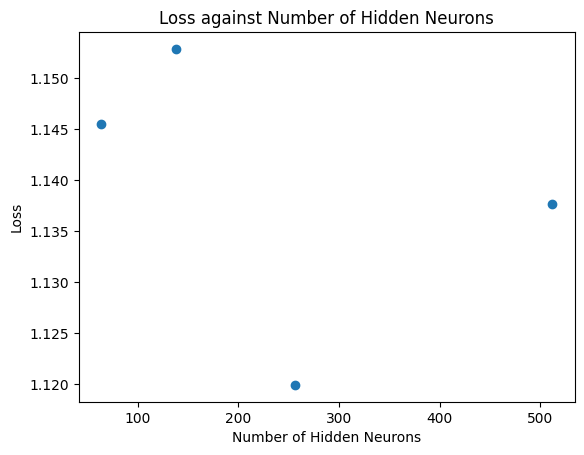

In [103]:
# Plot dev loss against batch size
plt.scatter(loss_hidden_dims.keys(), loss_hidden_dims.values())
plt.xlabel("Number of Hidden Neurons")
plt.ylabel("Loss")
plt.title("Loss against Number of Hidden Neurons")

256